In [1]:
#Uncomment if use Colab
'''from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive
'''

"from google.colab import drive\ndrive.mount('/content/gdrive', force_remount=True) #mount google drive\n"

In [205]:
# Nothing better to begin with than by importing some necessary dependencies. 
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt
import datetime
import random
import math

print("Cuda Available: " + str(torch.cuda.is_available()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is: " + str(device))
torch.set_default_tensor_type('torch.cuda.FloatTensor')
print("Done.")

Cuda Available: True
Device is: cuda
Done.


# ECS269U/P - Coursework


* The **goal** of the CW is similar to that of Week 2's Lab: fitting a curve to data, also known as **curve fitting**. 
* This has applications in many different disciplines that make use of AI: FinTech, Physics Modelling, or even Sports. 
* For example, we might be interested in learning the evolution (over time) of the price of a specific product in different countries. This can depend on several factors: the product itself, the country, the initial value of the product's price, etc. 
* As usual, we are interested in learning a model that finds these relationships *from the data*. 


### Learning a family of functions

* The main difference with Week 2's Lab is that we will learn a network that does not learn a single function but a *family of functions*.
* We will consider a family of sinusoidal functions. 
* Below you can find the code generating the data according to different random sinusoidal functions $\{f_a\}$. We randomly generate a set of 40 points in the x-axis in the interval $[-2, 2]$, slightly randomly shifted. Our functions will have the form of $y = f_a(x) = a * sin(x+a)$ where each $a$ will be randomly sampled for each function from interval $[-2, 2]$.  To "draw" a function $f_a$, we first choose some $a \sim U(-2,2)$ and then we compute $f_a$ using the above formula for all the $x$ in the x-axis. 


Done.


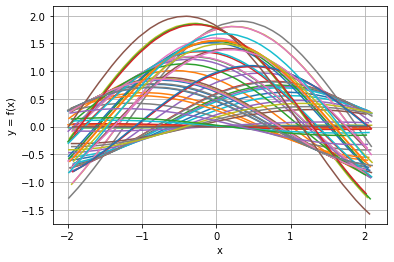

In [26]:
#TRAINING DATA

Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1) 
#print("Size of Tensor X: '" + str(x.size()) + "'") #2000 x 40 x 1
for k in range(Nf):
    #Creates a one-dimensional tensor of size Npt whose values are evenly spaced from -2 to 2
    x[k,:,0] = torch.linspace(-2, 2, Npts) #The second dimention (":") is replaced with a linespace
    '''
    Example of one of the 2000 rows of tensors:
    tensor([-2.0000, -1.8974, -1.7949, -1.6923, -1.5897, -1.4872, -1.3846, -1.2821,
            -1.1795, -1.0769, -0.9744, -0.8718, -0.7692, -0.6667, -0.5641, -0.4615,
            -0.3590, -0.2564, -0.1538, -0.0513,  0.0513,  0.1538,  0.2564,  0.3590,
             0.4615,  0.5641,  0.6667,  0.7692,  0.8718,  0.9744,  1.0769,  1.1795,
             1.2821,  1.3846,  1.4872,  1.5897,  1.6923,  1.7949,  1.8974,  2.0000])
    '''
    #print(x[k][:])

#torch.rand_like - Returns a tensor with the same size as x that is filled with random numbers from a uniform distribution
#xis've values are each incremented bu a randome value between 0 and 1 multiplied by 0.1
x += torch.rand_like(x)*0.1 #Adds noise

'''
Example of one of the 2000 rows of tensors:
tensor([-1.9522, -1.8191, -1.7578, -1.6236, -1.5726, -1.4080, -1.3814, -1.1981,
        -1.1180, -1.0590, -0.9221, -0.8150, -0.6727, -0.6026, -0.4707, -0.4150,
        -0.3416, -0.2539, -0.1080,  0.0440,  0.1186,  0.1915,  0.2743,  0.4412,
         0.5495,  0.6307,  0.7536,  0.8516,  0.8962,  1.0273,  1.1003,  1.2476,
         1.3009,  1.4816,  1.4950,  1.6820,  1.7111,  1.8184,  1.9137,  2.0498])
'''
#print(x[1,:,0])

#torch.rand(nf) - Returns a tensor filled with random numbers from a uniform distribution (of size nf)
#view(-1,1) - transposed a
#repeat(1, Npts) - Repeats this tensor along the specified dimensions
#unsqueeze - Returns a new tensor with a dimension of size 2 inserted at the specified position

'''
a = -2 + 4*torch.rand(Nf)
print(a)
print(a.size())

>>>Size 1 x 2000:
tensor([ 0.7274, -1.4469, -0.4797,  ...,  1.0672,  0.8241, -0.9555])
'''

'''
a = -2 + 4*torch.rand(Nf).view(-1,1)
print(a)
print(a.size())

>>>Size 2000 x 1
tensor([[ 0.9499],
        [ 0.9322],
        [-1.5867],
        ...,
        [ 1.4436],
        [ 1.3854],
        [-1.8810]])
'''
'''
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts)
print(a)
print(a.size())

>>>size 2000 x 40
tensor([[ 0.6778,  0.6778,  0.6778,  ...,  0.6778,  0.6778,  0.6778],
        [-0.9006, -0.9006, -0.9006,  ..., -0.9006, -0.9006, -0.9006],
        [ 0.9101,  0.9101,  0.9101,  ...,  0.9101,  0.9101,  0.9101],
        ...,
        [-1.5539, -1.5539, -1.5539,  ..., -1.5539, -1.5539, -1.5539],
        [-1.9478, -1.9478, -1.9478,  ..., -1.9478, -1.9478, -1.9478],
        [ 1.4272,  1.4272,  1.4272,  ...,  1.4272,  1.4272,  1.4272]])
'''

'''
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
print(a)
print(a.size())
>>>Size 2000 x 40 x 1
tensor([[[ 1.2147],
         [ 1.2147],
         [ 1.2147],
         ...,
         [ 1.2147],
         [ 1.2147],
         [ 1.2147]],

        [[ 0.1888],
         [ 0.1888],
         [ 0.1888],
         ...,
         [ 0.1888],
         [ 0.1888],
         [ 0.1888]],

        [[ 1.7409],
         [ 1.7409],
         [ 1.7409],
         ...,
         [ 1.7409],
         [ 1.7409],
         [ 1.7409]],

        ...,

        [[-1.4292],
         [-1.4292],
         [-1.4292],
         ...,
         [-1.4292],
         [-1.4292],
         [-1.4292]],

        [[ 0.2444],
         [ 0.2444],
         [ 0.2444],
         ...,
         [ 0.2444],
         [ 0.2444],
         [ 0.2444]],

        [[-1.8556],
         [-1.8556],
         [-1.8556],
         ...,
         [-1.8556],
         [-1.8556],
         [-1.8556]]])
torch.Size([2000, 40, 1])
'''

a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a) #y = fa(x) = a ∗ sin(x + a)

'''
print(y.size())
print(y)
Tesor Y - 2000 x 40 x 1
tensor([[[-1.0760],
         [-0.9916],
         [-0.7916],
         ...,
         [-0.0500],
         [-0.1530],
         [-0.4106]],

        [[-0.1495],
         [-0.1511],
         [-0.1518],
         ...,
         [ 0.1400],
         [ 0.1287],
         [ 0.1189]],
'''

#testArray = [[[1],[2],[3]],[[1],[2],[3]],[[1],[2],[3]]]
#print(testArray[0][:][1])

#Test data visualisation
for i in range(60):
    plt.plot(x[i].to('cpu'), y[i].to('cpu'))

#print(y.size())
#print(x.size())

plt.grid();
plt.xlabel('x');
plt.ylabel('y = f(x)');

print("Done.")

## The Learning Goal

* Because we are dealing with a family of functions and not just a single function, our model must be able to perform two tasks: *Function Selection* and *Regression*.
* Function selection means that given some *additional* input (to be defined below) the model somehow must choose which function $f_a$ from the family of functions $\{f_a\}$ it needs to model.
* Once the correct function is picked then the model must perform regression i.e. learn the relationship $y=f_a(x)$.




## The Learning Objective

* During training we randomly sample functions from the family of functions $\{f_a\}$. For each $f_a$, we are provided with the (input, output) pairs $(x_t, y_t), t=1,\dots,N_{pts}$.

* To perform *Function Selection*, a **random subset** of $(x_t, y_t), t=1,\dots,N_{pts}$ is provided as auxiliary input to the model during *both training and testing*. These auxiliary data is called the *context data:* $(x_c, y_c), c=1,\dots,N_c$. 

* Note that the total number of context points $N_c$ should be different (and randomly chosen) for every batch so that the model learns to handle different number of context points at test time. This means that the model should be able to work for e.g. $N_c=5$ but also for $N_c=12$ etc.

* Our model will take the context pairs $(x_c, y_c)$ and input values $x_t$ and will produce the estimated values $\hat{y}_t$. 

* During training we have access to the ground-truth values $y_t$, and thus we can compute a loss between the model's predictions $\hat{y}_t$ and the ground-truth values $y_t$.  


## The Model

* Our model will consists of 2 MLPs which must be jointly trained.
* The first MLP is called the *Context Encoder* or Encoder. The Encoder will take as input each pair $(x_c, y_c)$ and will produce a corresponding feature representation $r_c$ of dimension $r_{dim}$.
* A total context feature is produced by averaging over all features: $r_C= \frac{1}{N}\sum_c r_c$.
* The second MLP is called the Decoder. It takes as input the $r_C$ and each input data $x_t$ and produces the model's prediction $\hat{y}_t$. 



![Model](CW1.png)



## Architectures

* The Encoder and the Decoder are **MLPs**. You can experiment with your own architectures. You can also choose to implement the following architectures:
    * *Encoder*: It will map the input pair $(x_c, y_c)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the feature representation $r_c$ of dimension $r_{dim}$.
    * *Decoder*: It will map the input pair $(r_C, x_t)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the model's prediction $\hat{y}_t$.

## Tasks

* You have to implement the following:
    1. Create the training dataset and dataloader (10%). 
    2. Create the Encoder and Decoder (20 + 20%). 
    3. Create the optimizer and the loss for your model (10%).
    4. Write the training script that will train the model and print the training loss (30%).
    5. Evaluate the model on some validation data. Plot some predictions. (10%). 

* You might want to explore the impact of the following design choices and hyperparameters:
    1. Number of hidden layers and $h_{dim}$, and  $r_{dim}$.
    1. Type of optimizer, batch-size and all relevant hyper-parameters from Week 5.

## Dataset and Dataloader


In [194]:
class sinFuncDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        #Stores features (the set of xt) and labelts (the set of yt) sperately
        self.features = features 
        self.labels = labels
        
    #Return the length of the dataset
    def __len__(self):
        return len(self.features)
        
    #Gets the features and labels of a selected function (indexed by "fPossition") from the set of functions (features and corresponding labels) stored in this dataset.
    def __getitem__(self, fPossition):
        #Stores a 2D copy of the featuers and labels of the indexed function 
        featuresOfFunction = self.features[fPossition].view(-1)
        labelsOfFunction = self.labels[fPossition].view(-1)
        #featuresOfFunction = torch.transpose(self.features[fPossition], -1, -2)
        #labelsOfFunction = torch.transpose(self.labels[fPossition], -1, -2)

        #Returns a tuple with the input and output data of the sampled functions
        return (featuresOfFunction, labelsOfFunction)

def selectContexts(xt, yt):
    #Selects a random number between 6 (randLowerB) and 35 (randUpperB) to be the selected number of context points
    randLowerB = 6
    randUpperB = 35
    randNoOfContexts = random.randint(randLowerB, randUpperB)

    #Records the batch size
    bSize = xt.size(0)
    
    #Selects the indexes of the feature and labels that will be selected as the context data
    contextIndexes = []
    for i in range(randNoOfContexts):
        index = random.randint(0,(Npts - 1))
        if index in contextIndexes:
            while index in contextIndexes:
                index = random.randint(0,(Npts - 1))
        contextIndexes.append(index)
    #Sorts indacies so the contexts can be retrieved in order
    contextIndexes.sort()
    
    #Makes a 1x40 tensor to store the context in (we will "randNoOfContexts" many context in the first few elements and leave the                 rest as 0)
    paddedXContexts = torch.zeros(bSize, randNoOfContexts)
    paddedYContexts = torch.zeros(bSize, randNoOfContexts) 

    #Uses the selected indexes to select data in the features tensor and labels tensor to grab the contexts we want and to put                    them int the new passed tensor
    for i in range(randNoOfContexts):
        paddedXContexts[:,i] = xt[:,contextIndexes[i]]
        paddedYContexts[:,i] = yt[:,contextIndexes[i]]

    #Returns a tuple with the input and output data of the sampled functions
    return (paddedXContexts, paddedYContexts)

#Sets dataloader batch size
batchSize = 50

#Splits the 2000 family of functions into a set of features and labels that will be used for testing (1800 of the first featues and labels) and a set of features and labels that will be used for validation (200 of the last featues and labels)
testFeatures = x[:1800]
testLabels = y[:1800]
#Cleates datasets and dataloaders with the data above
trainingDataset = sinFuncDataset(testFeatures, testLabels)
trainingLoader = torch.utils.data.DataLoader(trainingDataset, batch_size=batchSize, shuffle=False)

#Uses the rest of the data for validation
validationFeatures = x[200:]
validationLabels = y[200:]
#Creates datasets and dataloaders with the data above
validationDataset = sinFuncDataset(validationFeatures, validationLabels)
validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size=1, shuffle=False)

#Full dataset
fullDataset = sinFuncDataset(x, y)
fullDatasetLoader = torch.utils.data.DataLoader(fullDataset, batch_size=batchSize, shuffle=False)

print("Done.")

Done.


In [195]:
#Dataloaders shape tests

#(xt, yt) = next(iter(trainingLoader))
(xt, yt) = fullDataset[0]

print(xt.shape)
print(yt.shape)
print("<============>")
print(xt)
print(yt)

print("Done.")

torch.Size([40])
torch.Size([40])
<============>
tensor([-1.9478, -1.8390, -1.7233, -1.6805, -1.5388, -1.3986, -1.3527, -1.2247,
        -1.1718, -1.0322, -0.9493, -0.8305, -0.7628, -0.6382, -0.5416, -0.3816,
        -0.2979, -0.1824, -0.1408,  0.0112,  0.0711,  0.2442,  0.3231,  0.4156,
         0.5038,  0.5654,  0.7001,  0.7777,  0.8962,  0.9761,  1.1441,  1.1959,
         1.3493,  1.4553,  1.5230,  1.6067,  1.7183,  1.8592,  1.9101,  2.0297])
tensor([-0.6019, -0.5821, -0.5535, -0.5411, -0.4929, -0.4354, -0.4147, -0.3525,
        -0.3250, -0.2483, -0.2004, -0.1295, -0.0882, -0.0112,  0.0486,  0.1465,
         0.1964,  0.2628,  0.2860,  0.3660,  0.3953,  0.4717,  0.5019,  0.5334,
         0.5592,  0.5746,  0.6007,  0.6108,  0.6192,  0.6199,  0.6085,  0.6016,
         0.5715,  0.5428,  0.5213,  0.4914,  0.4462,  0.3813,  0.3559,  0.2928])
Done.


## Encoder, Decoder And Model

In [196]:
class Encoder(nn.Module):
    def __init__(self, inpSize=2, hDim=2, rDim=2):
        super(Encoder, self).__init__()
        #The Encoder will take the tensor with the context pairs and feed it into multiple linear regression layers to get rdim many outputs. It will use the ReLU activation function inbetween layers to add Non-linearities  
        self.inpSize = inpSize #Size of input features 
        self.outSize = rDim #Size out output features

        #Models and activation functions
        self.linLayer1 = nn.Linear(inpSize, hDim)
        self.activationFunc1 = nn.Tanh()
        self.linLayer2 = nn.Linear(hDim, hDim)
        self.activationFunc2 = nn.Tanh()
        self.linLayer3 = nn.Linear(hDim, rDim) 

        #intialises model weights (with a uniform distribution) and bais(with 0)
        torch.nn.init.normal_(self.linLayer1.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer1.bias)  
        torch.nn.init.normal_(self.linLayer2.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer2.bias)  
        torch.nn.init.normal_(self.linLayer3.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer3.bias)   
         
    #Returns the output of feeding the input features into the first defined linear model, a ReLU activation function and then the second defined linear model, another relu activation function and finally a 3rd linear model
    def forward(self, contextData):  
        linLayerOut1 = self.linLayer1(contextData)
        activationOut1 = self.activationFunc1(linLayerOut1)
        linLayerOut2 = self.linLayer2(activationOut1)
        activationOut2 = self.activationFunc2(linLayerOut2)
        linLayerOut3 = self.linLayer3(activationOut2)
        
        #Returns the mean of the output (which will be a single value - per input features provided)
        return torch.mean(linLayerOut3, 1, True)

print("Done.")

Done.


In [197]:
class Decoder(nn.Module):
    def __init__(self, inpSize=3, outSize=1, hDim=2):
        super(Decoder, self).__init__()
        #The Decoder will take the input data of a function(40 in this case), pair it with output of the encoder (which will be a single 2 dimentional vector that is prepended onto every input feature) and feed it into several linear regression layer to get a single output/prediction for each input feature. It will use the ReLU activation function to add Non-linearities in between linear layers  
        self.inpSize = inpSize #Size of input features 
        self.outSize = outSize #Size out output features
        self.hDim = hDim #hidden layer dimentions

        #Models and activation functions
        self.linLayer1 = nn.Linear(inpSize, hDim)
        self.activationFunc1 = nn.Tanh()
        self.linLayer2 = nn.Linear(hDim, hDim)  
        self.activationFunc2 = nn.Tanh()
        self.linLayer3 = nn.Linear(hDim, outSize)  

        #intialises model weights and bais
        torch.nn.init.normal_(self.linLayer1.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer1.bias)  
        torch.nn.init.normal_(self.linLayer2.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer2.bias)  
        torch.nn.init.normal_(self.linLayer3.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer3.bias)  
         
    #Feeds the data set into the models and activation function defined above
    def forward(self, inputData):
        linRegOut1 = self.linLayer1(inputData)
        activationOut1 = self.activationFunc1(linRegOut1)
        linRegOut2 = self.linLayer2(activationOut1)
        activationOut2 = self.activationFunc2(linRegOut2)
        linRegOut3 = self.linLayer3(activationOut2)

        return linRegOut3
    
print("Done.")

Done.


In [198]:
class Model(nn.Module):
    def __init__(self, ctxDim=2, outDim=1, rDim=2, hDim=2):
        super(Model, self).__init__()
        #ctxDim is 2 since we have 2 pairs of context point, which we will feed into the model
        self.encoder = Encoder(ctxDim, hDim, rDim)
        #inpSize + 1 - the size of the input output pair (2) plus the rc value that is appendeded to it (rc is the output of the decoder)
        self.decoder = Decoder((rDim + 1), outDim, hDim)

    #Glues together the encoder and decoder by combining the encoder's output to the decoder's input and feeding that combination to the decoder
    def forward(self, contextPairs, inputFeatures):
        encoderInput = torch.stack((contextPairs[0], contextPairs[1]),-1)
        encoderOutput = self.encoder(encoderInput)
        encoderOutputR = encoderOutput.repeat(1, inputFeatures.size(-1), 1)

        #Concatinates the input features with the encoder's output (which is repeated across each input feature) 
        decoderInput = torch.cat((encoderOutputR, inputFeatures.unsqueeze(-1)), dim=2)
        #Feeds the concatinated tensor to the decoder
        decoderOutput = self.decoder(decoderInput)
        #returns the output of the decoder
        return decoderOutput.squeeze(-1)

print("Done.")

Done.


## optimizer And Loss

In [199]:
#Loss function initialisation
lossFunction = nn.MSELoss()
#def lossFunction(prediction, groundTruth):
    #loss = (prediction - groundTruth).pow(2).sum()

#Model dimentions
ctxDim = 2 #Don't change
outDim = 1 #Don't change
hDim = 200
rDim = 10

#Model initialisation
myModel = Model(ctxDim, outDim, rDim, hDim)
myModel.to(device)

#Hyperparameter initialisation
learningRate = 0.001
weightDecay = 0.0005

#Optimiser initilisation
myOptimizer = torch.optim.Adam(myModel.parameters(), lr=learningRate) #, weight_decay=weightDecay)

print(myModel)
print("Done.")

Model(
  (encoder): Encoder(
    (linLayer1): Linear(in_features=2, out_features=200, bias=True)
    (activationFunc1): Tanh()
    (linLayer2): Linear(in_features=200, out_features=200, bias=True)
    (activationFunc2): Tanh()
    (linLayer3): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (linLayer1): Linear(in_features=11, out_features=200, bias=True)
    (activationFunc1): Tanh()
    (linLayer2): Linear(in_features=200, out_features=200, bias=True)
    (activationFunc2): Tanh()
    (linLayer3): Linear(in_features=200, out_features=1, bias=True)
  )
)
Done.


## Training Script

In [187]:
def trainer(model, dataLoader, optimiser, noOfEpoch, validationMode=False, traceEpochLoss=False, traceBatchLoss=False, printPerEpoch=1,progressBarInterval=1):
    #Holds loss
    accumlativeBatchLoss = 0.0 #Total loss for batch
    accumlativeEpochLoss = 0.0 #Total loss for epoch
    accumlativeLoss = 0.0 #Total loss for an interval

    #Sets the model to validation mode is validationMode is set to true
    if validationMode == False:
        model.train()
        torch.set_grad_enabled(True) #Tracks gradients
        datasetSize = len(trainingDataset)
        print("---TRRAINIG MODE---")
    else:
        model.eval()
        torch.set_grad_enabled(False) #Doesn't track gradients
        datasetSize = len(validationDataset)
        print("---VALIDATION MODE---")

    #Arrays for tracking the history of loss per epoch and per batch - the training function returns these
    epochLossHistory = []
    batchLossHistory = []
    generalLossHistory = []

    #Strings for progress bars when tracking per group of epochs
    for epoch in range(noOfEpoch):
        accumlativeEpochLoss = 0.0
        accumlativeLoss = 0.0

        if printPerEpoch > 1 and epoch % printPerEpoch == 0 and epoch != 0:
            print("]")
            print("------------------------------------------------\n\n")
            print("")

        #Tracks time taken per epoch or group of epochs
        if traceEpochLoss == True and (epoch % printPerEpoch == 1 or epoch == 0 or printPerEpoch == 1):
            startTime = datetime.datetime.now().replace(microsecond=0)

        #Counts the amount of data that has been iterated through
        progressCounter = 1 
        
        #If epoch trace flag is set, this insidcates the current epoch
        if traceEpochLoss == True and epoch % printPerEpoch == 0:
            print("Current Epoch [" + str(epoch+1) + "]: ")

        #Goes through data loader to train model for the current epoch
        for data in dataLoader:
            #Resets batch history
            accumlativeBatchLoss = 0.0

            #Loads data into seperate variables
            (features, groundTruth) = data
            (xContext, yContexts) = selectContexts(features, groundTruth)

            #print("noOfNCs: " + str(xContext.size(1)))

            #Attempts to use GPU/CUDA for processing the dataset
            xContext.to(device)
            yContexts.to(device)
            features.to(device)
            groundTruth.to(device)

            #Set the parameter gradients to 0
            optimiser.zero_grad()
            #Feeds the model the context data and features
            predictions = model((xContext, yContexts), features)

            #print("Test")
            #print("Pre: " + str(predictions.shape))
            #print("GT: " + str(groundTruth.shape))
            #print("Pre[0]: " + str(predictions[:][:][0]))
            
            #Calculates and stores the loss
            loss = lossFunction(predictions, groundTruth)
            
            #For debugging
            #print("-----")
            #print(predictions)
            #print(groundTruth)
            #print("-----")

            #Trains model if valationd mode is not set to true
            if validationMode == False:
                loss.backward()
                optimiser.step()

            #Record the amount of data that have been accumalatively used for training at at the current batch
            progressCounter += batchSize

            #Retrieves the batch's loss
            currentLoss = loss.item()
            #Records the batch's average loss - resets per batch
            accumlativeBatchLoss += currentLoss 
            #Records all the batch's average loss during the epoch - resets per epoch
            accumlativeEpochLoss += currentLoss
            #Records the total loss (the average loss multplied by the batch size)
            accumlativeLoss += currentLoss * features.size(0)     

            #This loss is used to find the average loss per a given set of epoch
            if epoch != 0:
                accumlativeGroupEpochLoss += currentLoss

            #Stores batch loss history
            batchLossHistory.append(currentLoss)

            #If epoch trace flag is set, prints batch loss of current epoch
            if traceEpochLoss == True and traceBatchLoss == True and epoch % printPerEpoch == 0:
                print("---- Batch " + str(progressCounter) + ": loss (per batch) = " + str(accumlativeBatchLoss))

        #Stores loss per epoch
        epochLossHistory.append(accumlativeEpochLoss)

        #Records the rate of loss per epoch (where accumlativeLoss is the batch's average loss * the numbr of features processed in the batch (which is between 1 and the batch size) and datasetSize is the length of the dataset that we are going through per epoch
        lossRateChange = accumlativeLoss / datasetSize 
        #Stores the average loss per epoch, per set of features assessed
        generalLossHistory.append(lossRateChange)  
        #For debuging:
        # print("-------------")
        #print("lossRateChange: " + str(lossRateChange))
        #print("accumlativeLoss: " + str(accumlativeLoss))
        #print("datasetSize: " + str(datasetSize))
        #print("-------------")

        #If epoch trace flag is set, prints info about the current epoch or set of processed epochs
        if traceEpochLoss == True and epoch % printPerEpoch == 0:
            print("\n>>>> Epoch Done! <<<<\n") 
            #Prints the average loss per featre assessed for the whole epoch
            print("Loss (Per input, per epoch): " + str(lossRateChange))

            #For groups of epochs, this prints the average lost per batch, per epoch
            if epoch == 0:
                print("Loss (Per batch, per epoch): " + str(accumlativeEpochLoss))
            else:
                print("Average loss after " + str(printPerEpoch) + " epoch(s) (Per batch, per epoch): " + str(accumlativeGroupEpochLoss/printPerEpoch))

            #Resets the loss recorded for the group of epochs
            accumlativeGroupEpochLoss = 0.0

            #Prints the time take for the group of epoch/single epoch
            endTime = datetime.datetime.now().replace(microsecond=0)
            timeTakesForEpoch = endTime - startTime
            print("Time taken for " + str(printPerEpoch) + " epochs: " + str(timeTakesForEpoch))
            print("<==============================================>\n")
            
            #Prints the progress of each group of epochs
            if printPerEpoch > 1:
                print("Progress of the next set of epochs: \n[#", end='')

        #Prints "#" to indicate the progress of a group of epochs
        if (printPerEpoch > 1) and (not(epoch % printPerEpoch == 0)) and (epoch % progressBarInterval == 0):
            print("#", end='')

    #Formats the progress bar after the last epoch
    if printPerEpoch > 1:
        print("]")
        print("------------------------------------------------")
    
    print("\n" + (str(noOfEpoch) + " Epochs completed."))

    #Returns the epoch and batch lost history
    return epochLossHistory, batchLossHistory, generalLossHistory
        
print("Done.")

Done.


In [188]:
epochLossHistoryTrain, batchLossHistoryTrain, genTrainLoss = trainer(myModel, fullDatasetLoader, myOptimizer, 1200, False, True, False, 1200, 50)
print("Done.")

---TRRAINIG MODE---
Current Epoch [1]: 

>>>> Epoch Done! <<<<

Loss (Per input, per epoch): 0.5068662191430727
Loss (Per batch, per epoch): 18.24718388915062
Time taken for 1200 epochs: 0:00:00
<==============================================>

Progress of the next set of epochs: 
[########################]
------------------------------------------------

1200 Epochs completed.
Done.


## Validation

In [219]:
'''
def validateModel(validationData, modelToValidate)
    #if isinstance(net, torch.nn.Module):
    modelToValidate.eval() 
    validationResults = []
    for batch, (inputFeatures, groundTruth) in enumerate(validationData):
        validationResults.append([0.0,0.0])



        metric.add(accuracy(net(X), y), d2l.size(y))


    return metric[0] / metric[1]

def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)        
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
'''

epochLossHistoryVali, batchLossHistoryVali, genValiLoss = trainer(myModel, validationLoader, myOptimizer, 1, True, True, False, 1) 
print("Done.")

---VALIDATION MODE---
Current Epoch [1]: 

>>>> Epoch Done! <<<<

Loss (Per input, per epoch): 0.5819396113840922
Loss (Per batch, per epoch): 1047.491300491366
Time taken for 1 epochs: 0:00:02
<==============================================>


1 Epochs completed.
Done.


In [228]:
def graphHistory(trBatchHistory, trEpochHistory, trLossPerInp, valBatchHistory, valEpochHistory, valLossPerInp):
    expandedValDStruct = [0.0 for i in range(len(trLossPerInp))]
    trDValDRatio = int(math.ceil(float(len(expandedValDStruct))/float(len(valLossPerInp))))
    
    print(len(valLossPerInp))
    for i in range(trDValDRatio):
        repeat = valLossPerInp[i]
        for i in range((i*trDValDRatio), ((i*trDValDRatio) + trDValDRatio)):
            if i >= len(expandedValDStruct):
                break
            expandedValDStruct[i] = repeat
    
    print(len(valLossPerInp))
    print(expandedValDStruct)

    plt.subplots(1, figsize=(10,10))
    plt.title('Loss History Of Batch - Per Epoch')
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss In Batch")
    plt.plot(trEpochHistory, label="Training Phase")
    #plt.plot(valEpochHistory, label="Validation Phase")
    plt.legend(loc='lower left')

    plt.subplots(1, figsize=(10,10))
    plt.title('Loss Per Batch')
    plt.grid()
    plt.xlabel("Batch")
    plt.ylabel("Average Loss Of Batch")          
    plt.plot(trBatchHistory, '*', label="Training Phase")
    #plt.plot(valBatchHistory, '*', label="Validation Phase")
    plt.legend(loc='lower left')

    plt.subplots(1, figsize=(10,10))
    plt.title('Loss History Of Individual Input Features - Per Epoch')
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")          
    plt.plot(trLossPerInp, label="Training Phase")
    plt.plot(expandedValDStruct, label="Validation Phase")
    plt.legend(loc='lower left')

In [229]:
graphHistory(batchLossHistoryTrain, epochLossHistoryTrain, genTrainLoss, batchLossHistoryVali, epochLossHistoryVali, genValiLoss)

1


IndexError: list index out of range

# Test data  

* Test data are stored in a dictionary where each key has the data for a single function $f_a$. We have generated 6 different functions named as `function_num_1`, `function_num_2` and so on. 

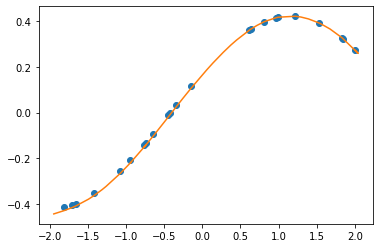

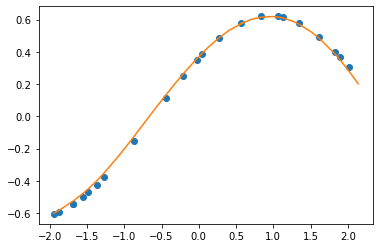

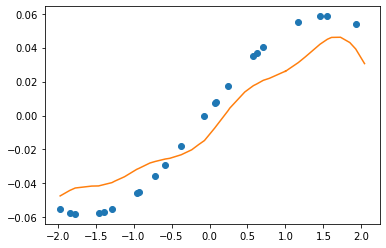

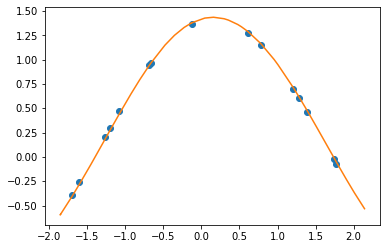

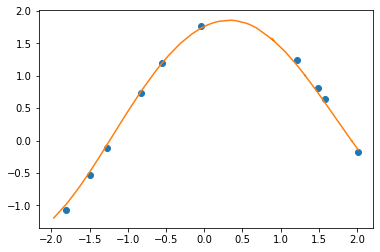

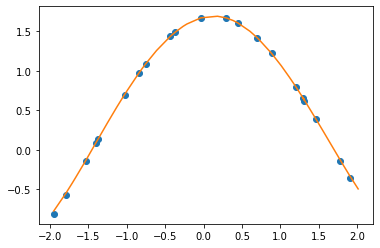

In [192]:
import pickle
path_to_the_pickle = 'test_data.pkl'
test_data = pickle.load(open(path_to_the_pickle,'rb'))

# 6 test functions - plots them on seperate graphs
for i in range(1,7):
    name = 'function_num_{}'.format(i)
    x_c = test_data[name]['context_pairs'][0].squeeze(-1).to(device)
    y_c = test_data[name]['context_pairs'][1].squeeze(-1).to(device)
    x_t = test_data[name]['x'].squeeze(-1).to(device)

    #print(x_c.squeeze(-1).shape)
    #print(y_c.squeeze(-1).shape)
    #print(x_t.squeeze(-1).shape)

    y_t = myModel((x_c, y_c), x_t)

    plt.subplots(1) 
    plt.plot(x_c[0].cpu(), y_c[0].cpu(), 'o') #plots example contexts
    plt.plot(x_t[0].cpu(), y_t[0].cpu().detach().numpy()) #plots prediction as a line - peplace x_t[0] with prediction

In [193]:
#Bulk
noOfXContextsInExample = x_c.size(1)
noOfYContextsInExample = y_c.size(1)
noOfContextsInExampleTotal = noOfXContextsInExample + noOfYContextsInExample

'''
<===================================================================================>

                #Selects a random number between 6 (randLowerB) and 35 (randUpperB) to be the selected number of context points
                randLowerB = 6
                randUpperB = 35
                randNoOfContexts = random.randint(randLowerB, randUpperB)
                
                #Selects the indexes of the feature and labels that will be selected as the context data
                contextIndexes = []
                for i in range(randNoOfContexts):
                    index = random.randint(0,(Npts - 1))
                    if index in contextIndexes:
                        while index in contextIndexes:
                            index = random.randint(0,(Npts - 1))
                    contextIndexes.append(index)
                #Sorts indacies so the contexts can be retrieved in order
                contextIndexes.sort()
                
                #Makes a 1x40 tensor to store the context in (we will "randNoOfContexts" many context in the first few elements and leave the                 rest as 0)
                paddedXContexts = torch.zeros(Npts)
                paddedYContexts = torch.zeros(Npts) 

                #Uses the selected indexes to select data in the features tensor and labels tensor to grab the contexts we want and to put                    them int the new passed tensor
                for i in range(randNoOfContexts):
                    paddedXContexts[i] = featuresOfFunction[contextIndexes[i]]
                    paddedYContexts[i] = labelsOfFunction[contextIndexes[i]]

                #Returns a tuple with the input and output data of the sampled functions
                return (paddedXContexts, paddedYContexts), (featuresOfFunction, labelsOfFunction)

<===================================================================================>

                paddedXContexts = []
                paddedYContexts = [] 

                for i in range(randNoOfContexts):
                    paddedXContexts.append(featuresOfFunction[contextIndexes[i]])
                    paddedYContexts.append(labelsOfFunction[contextIndexes[i]])

                paddedXContexts = torch.tensor(paddedXContexts)
                paddedYContexts = torch.tensor(paddedYContexts)

<===================================================================================>

#Picks one of the 2000 functions to model
def pickFunction(functionInpSet, functionOutSet):
    choosenFunctionIndex = random.randint(0, functionInpSet.size(0))
    print("Function '" + str(choosenFunctionIndex) + "' Choosen")
    return [functionInpSet[choosenFunctionIndex], functionOutSet[choosenFunctionIndex]]

#Picks a random number of context pairs for a function 
def pickContectPairs(xInps, yOuts):
    #Picks number between 1 and 40 (40 being the number of inputs/outputs of the choosen family of functions)
    randNoOfContexts = random.randint(1,xInps.size(0))
    #Seclects the indexes of the input and outputs that will be selected as the context data
    contextIndexes = []
    for i in range(randNoOfContexts):
        index = random.randint(0,xInps.size(0)-1)
        if index in contextIndexes:
            while index in contextIndexes:
                index = random.randint(0,xInps.size(0)-1)
        contextIndexes.append(index)
    #Sorts indacies so the contexts can be retrieved in order
    contextIndexes.sort()
    #Uses indacies to extract contexts from the input and output tensor and converts the array structures they're stored in     into tensors
    print("Selected Context Indicies: " + str(contextIndexs))
    xContexts = [xInps[contextIndexes[i]] for i in range(len(contextIndexes))]
    yContexts = [yOuts[contextIndexes[i]] for i in range(len(contextIndexes))]
    xContexts = torch.unsqueeze(torch.tensor(xContexts), 1)
    yContexts = torch.unsqueeze(torch.tensor(yContexts), 1)
    #print("X Contexts: " + str(xContexts))
    #print("Y Contexts: " + str(yContexts))
    return [xContexts, yContexts]
'''

'\n<===================================================================================>\n\n                #Selects a random number between 6 (randLowerB) and 35 (randUpperB) to be the selected number of context points\n                randLowerB = 6\n                randUpperB = 35\n                randNoOfContexts = random.randint(randLowerB, randUpperB)\n                \n                #Selects the indexes of the feature and labels that will be selected as the context data\n                contextIndexes = []\n                for i in range(randNoOfContexts):\n                    index = random.randint(0,(Npts - 1))\n                    if index in contextIndexes:\n                        while index in contextIndexes:\n                            index = random.randint(0,(Npts - 1))\n                    contextIndexes.append(index)\n                #Sorts indacies so the contexts can be retrieved in order\n                contextIndexes.sort()\n                \n                